In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.model_selection import train_test_split
#from math import exp
import matplotlib.pyplot as plt
df = pd.read_csv('wisconsonbc.csv')
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [19]:
#smaller dataframe
df = df[['diagnosis', 'radius_mean', 'texture_mean']]

# Diagnosis is Malignant of benign
varray = df['diagnosis'].unique()
varray

array(['M', 'B'], dtype=object)

In [20]:
# Make the diagnosis 1 if malignant and 0 if benign
df = pd.get_dummies(df)
df.head()

,radius_mean,texture_mean,diagnosis_B,diagnosis_M
0,17.99,10.38,0,1
1,20.57,17.77,0,1
2,19.69,21.25,0,1
3,11.42,20.38,0,1
4,20.29,14.34,0,1


In [21]:
# Use diagnosis_M for the response variable
y,X = dmatrices('diagnosis_M ~ radius_mean', data=df, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
model1 = sm.Logit(y_train, X_train).fit()
model1.summary()

Optimization terminated successfully.
         Current function value: 0.267530
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            diagnosis_M   No. Observations:                  455
Model:                          Logit   Df Residuals:                      453
Method:                           MLE   Df Model:                            1
Date:                Wed, 18 Oct 2017   Pseudo R-squ.:                  0.5952
Time:                        16:42:53   Log-Likelihood:                -121.73
converged:                       True   LL-Null:                       -300.69
                                        LLR p-value:                 7.957e-80
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -16.1346      1.594    -10.120      0.000     -19.259     -13.010
radius_mean     1.0907      0.112      9.773      0.000       0.872       1.309
===============================================================================
"""

In [22]:
# use the model coefficients to plot the curve to the data
h = lambda x: 1/(1 + np.exp(-1*(model1.params[0] + model1.params[1]*x)))

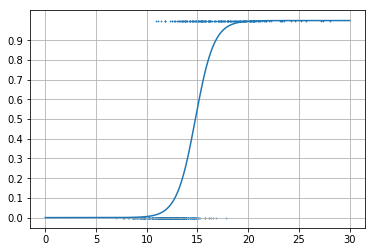

In [23]:
# Show the logistic regression model
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca()
ax.set_yticks(np.arange(0, 1., 0.1))

plt.scatter(df['radius_mean'], df['diagnosis_M'], s = 0.5)
xPlot = np.linspace(0, 30, 300)
y_hat = h(xPlot)
plt.plot(xPlot, y_hat)
plt.grid()
plt.show()

In [24]:
# 2 predictors...
y2,X2 = dmatrices('diagnosis_M ~ radius_mean + texture_mean', data=df, return_type='dataframe')
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=1)
model2 = sm.Logit(y2_train, X2_train).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.230679
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            diagnosis_M   No. Observations:                  455
Model:                          Logit   Df Residuals:                      452
Method:                           MLE   Df Model:                            2
Date:                Wed, 18 Oct 2017   Pseudo R-squ.:                  0.6509
Time:                        16:42:54   Log-Likelihood:                -104.96
converged:                       True   LL-Null:                       -300.69
                                        LLR p-value:                 9.884e-86
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -21.6892      2.279     -9.518      0.000     -26.156     -17.223
radius_mean      1.1516      0.129      8.951      0.000       0.899       1.404
texture_mean     0.2386      0.044      5.401      0.000       0.152       0.325
================================================================================
"""

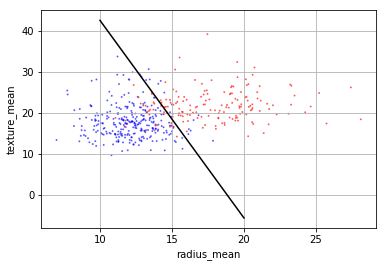

In [25]:
# plot the decision boundary
cs = y2_train['diagnosis_M'].map({0:'b', 1:'r'})
f,ax = plt.subplots()
ax.scatter(X2_train['radius_mean'], X2_train['texture_mean'], color=cs, s=1, alpha=0.5)
bxs = np.linspace(10, 20, 100)
z = lambda x: -(model2.params[0] + model2.params[1]*x)/model2.params[2]  
bys = z(bxs)
#bys
ax.plot(bxs, bys, color = 'black')
ax.set_xlabel('radius_mean')
ax.set_ylabel('texture_mean')
ax.grid()
plt.show()

In [26]:
# look for false positives and false negative statistics
confusion = model2.pred_table()
confusion

array([[ 268.,   17.],
       [  29.,  141.]])

In [27]:
accuracy = np.diag(confusion).sum()/confusion.sum()
accuracy

0.89890109890109893

In [28]:
tp = confusion[1,1]
fp = confusion[0,1]
tn = confusion[0,0]
fn = confusion[1,0]
#precision
precision = tp / (tp + fp)
recall = tp / (tp + fn)
precision, recall

(0.89240506329113922, 0.8294117647058824)

In [29]:
#plot precision, recall for different thresholds
def pr(model,thresh):
    c = model2.pred_table(threshold=thresh)
    tp = confusion[1,1]
    fp = confusion[0,1]
    tn = confusion[0,0]
    fn = confusion[1,0]
    #precision
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return precision, recall

In [30]:
thresholds = np.arange(0.1, 0.9, .1)
results = [pr(model2, t) for t in thresholds]
